## Distance map

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

def plot_map(map, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(map)

def create_points(batch_size, num_points, seed=42):
  np.random.seed(seed)
  coords = np.random.rand(batch_size, num_points, 2)
  return coords


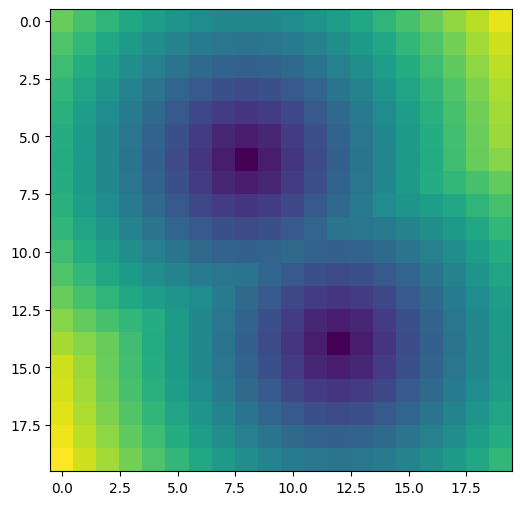

In [ ]:
# Implementation with for loop, for comparison

def min_dist_iter(points, res):
    """A simple iterative implementation of min_dist for comparison.
    """
    def distance(x, y):
        return ((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2) ** 0.5

    shifted = np.array(points) * res
    coords = np.array(list(itertools.product(range(res), range(res))))

    dist_map_list = []
    for coord in coords:
        dists = []
        for point in shifted:
            dists.append(distance(coord, point))
        dist_map_list.append(min(dists))

    dist_map = np.array(dist_map_list).reshape((res, res)).T
    return dist_map

distance_to_data = min_dist_iter([[0.4, 0.3], [0.6, 0.7]], 20)
plot_map(distance_to_data)

In [ ]:
# Implementation without for loop
def min_dist(points, res):
    """Calculates a 2D tensor with the minimum distance from each pixel to data.

    Inputs:
        * points: a python list of 2D coordinates, normalized in the range [0,1]
        * res: the resolution of the output tensor.
    Returns:
        A res x res square tensor with floating point values corresponding to the
        euclidean distance to the closest point in points.
    """
    shifted = torch.tensor(points, dtype=torch.float32) * res
    coords = torch.tensor(list(itertools.product(range(res), range(res))), dtype=torch.float32)
    dist_map = torch.cdist(coords, shifted).min(dim=1).values.reshape((res, res)).T
    return dist_map

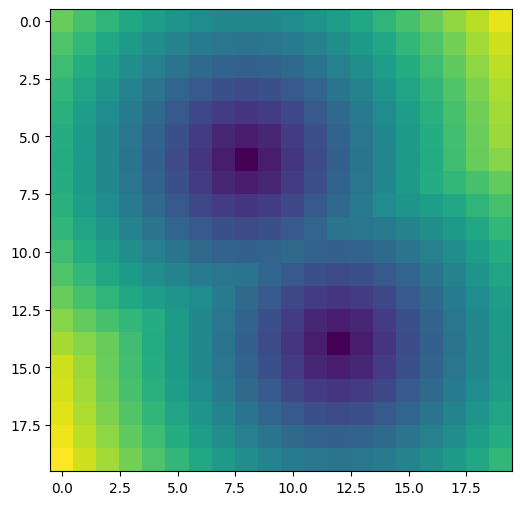

In [ ]:
# Case 1:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plot_map(distance_to_data)

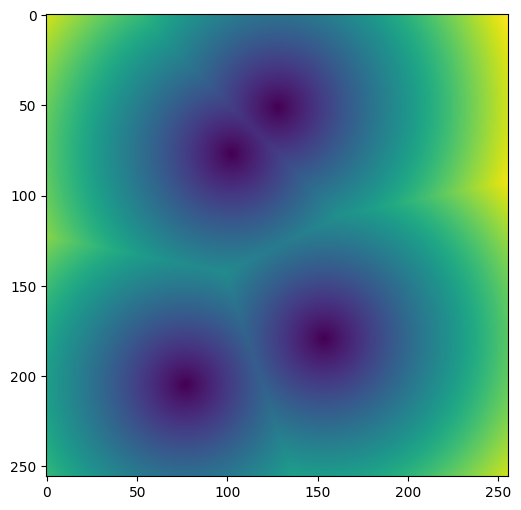

In [ ]:
# Case 2:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256)
plot_map(distance_to_data)

# Part 3-1b: Batched version

As a next step, improve the `min_dist` function to support batches.
The `points` array is now expected to be a tensor with shape [batch_size, num_points, 3], generated by `create_points`.
`min_dist` should return a batch of maps with shape [batch_size, res, res].
Again, make sure to implement `min_dist` using **no for-loops**.
Demonstrate your function output with `batch_size=3` and `num_points=4`.

In [ ]:


def min_dist_batch(points: np.ndarray, res):
    """Calculates a 3D tensor with the minimum distance from each pixel to data.

    Inputs:
        * points: a numpy array of 2D coordinates and point values, normalized to
                be in the range [0,1]. The expected shape is [B, P, 2].
        * res: the resolution of the output tensor.
    Returns:
        A res x res square tensor with floating point values corresponding to the
        euclidean distance to the closest point in points. The return tensor
        shape is [B, res, res].
    """
    n_batches = points.shape[0]
    shifted = torch.tensor(points * res, dtype=torch.float32)
    coords = torch.tensor([list(itertools.product(range(res), range(res)))] * n_batches, dtype=torch.float32)
    dist_map = torch.cdist(coords, shifted).min(dim=2).values.reshape(n_batches, res, res).mT
    return dist_map



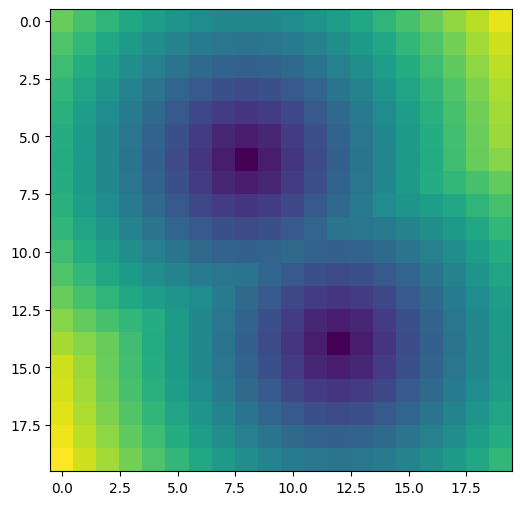

In [ ]:
# Case 1
batched_points = np.array([[[0.4, 0.3], [0.6, 0.7]]])
distance_to_data = min_dist_batch(batched_points, 20)
plot_map(distance_to_data[0])

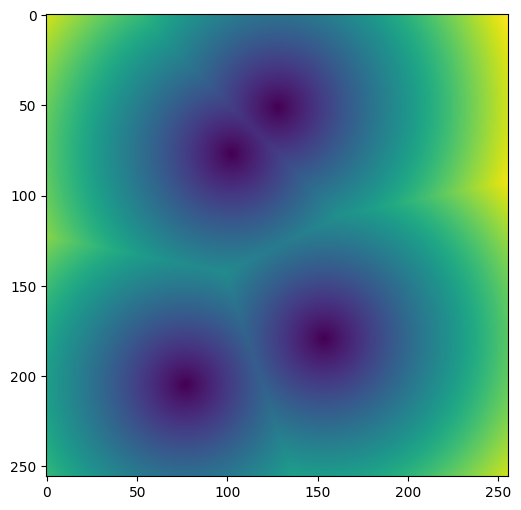

In [ ]:
# Case 2:
batched_points = np.array([[[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]]])
distance_to_data = min_dist_batch(batched_points, 256)
plot_map(distance_to_data[0])

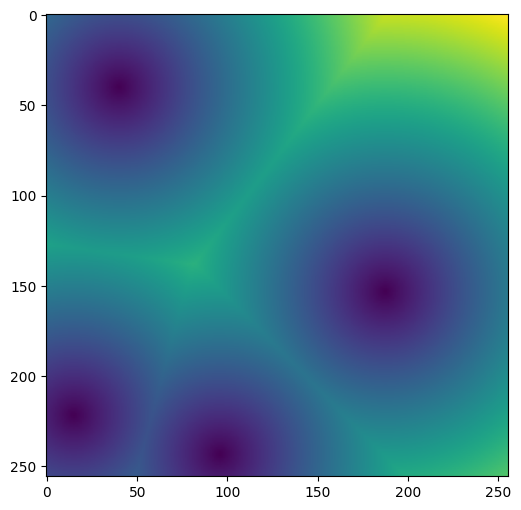

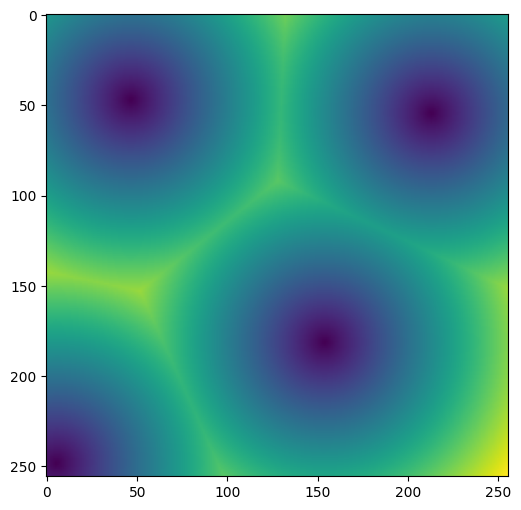

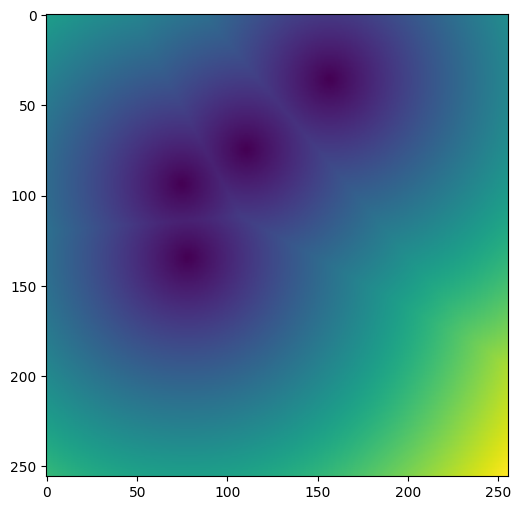

In [ ]:
# Case 3:
batched_points = create_points(3, 4, seed=42)
distance_to_data = min_dist_batch(batched_points, 256)
plot_map(distance_to_data[0])
plot_map(distance_to_data[1])
plot_map(distance_to_data[2])

# Part 3-2: Scalable version

Assume `res` can be very large (up to 65,536). Running the above function will likely cause the computer's RAM to be filled up, and fail (on a free colab instance, even 16,384 `res` will crash with `batch_size=3` and `num_points=4`).
Extend the above version of `min_dist` to calculate the result tensor at such high resolution without running out of RAM. This function may be less computationally efficient, as long as it can successfully run.

In [ ]:

def min_dist_scalable(
    points: np.ndarray,
    res: int,
    chunk_size: int = 1000,
    device: str = "cpu",
    dtype: torch.dtype = torch.float32
  ) -> torch.Tensor:
    """Scalable version of the min_dist function.
    How it works:
    1. Iterate through each batch of points
    2. Create a cartesian product of x-y coordinates, representing the res * res map
    3. Process the pixels in chunks:
        - Each time take a slice of `chunk_size` from the cartesian product,
        - Calculate distance of the current chunk to the data points, and take the smallest distance
    4. Join all coordinate batches's distance tensor to create this point batch's distance map
    5. Finally, Stack all batches' distance maps to create the final output

    Parameters
    ----------
    points : np.ndarray
        a numpy array of 2D coordinates and point values, normalized to
        be in the range [0,1]. The expected shape is [B, P, 2].
    res : int
        the resolution of the output tensor.
    chunk_size : int, optional
        Number of coordinates in the map to be processed at one time, by default 1000
    dtype: torch.dtype
        Controlling the data type of the tensor used in calculations.

    Returns
    -------
    torch.Tensor
        A res x res square tensor with floating point values corresponding to the
        euclidean distance to the closest point in points. The return tensor
        shape is [B, res, res].
    """
    points = torch.tensor(points, dtype=dtype).to(device)
    map_size = res * res
    output = torch.empty((points.shape[0], map_size), dtype=dtype).to(device)
    n_batches = points.shape[0]

    # Iterate through each point batch
    for batch_idx, batch_points in enumerate(points):
        filled = 0

        # Create a cartesian product of x-y coordinates
        prod = itertools.product(range(res), range(res))

        shifted = (batch_points * res).to(device)

        # Iterate through the coordinates by chunk_size
        iterator = tqdm(
            range(0, map_size, chunk_size),
            total=int(np.ceil(map_size/chunk_size)),
            unit = "chunk",
            desc=f"Batch {batch_idx}"
        )

        for i in iterator:

            # Take a slice of chunk_size from the prod generator
            chunk = list(itertools.islice(prod, 0, chunk_size))
            coords = torch.tensor(chunk, dtype=dtype).to(device)

            # Calculate distance of the current chunk
            output[batch_idx, filled:filled + len(chunk)] = torch.cdist(coords, shifted).min(dim=1).values
            filled += len(chunk)

    return output.view(n_batches, res, res).mT.to("cpu")


## Small examples

Batch 0: 1chunk [00:00, 221.36chunk/s]


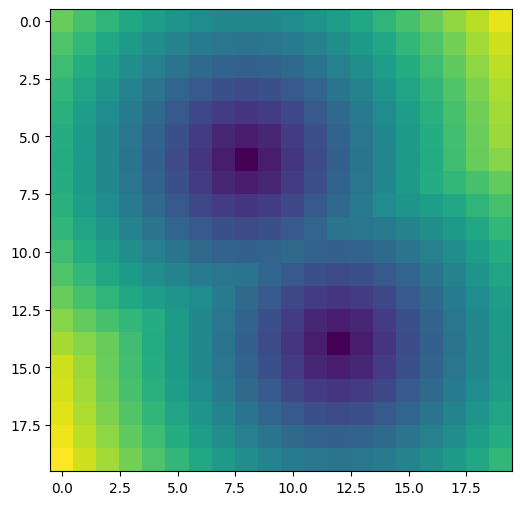

In [ ]:
# Case 1
points = np.array([[[0.4, 0.3], [0.6, 0.7]]])
plot_map(min_dist_scalable(points, 20, 1000)[0], figsize=(6, 6))

Batch 0: 1chunk [00:00, 40.55chunk/s]


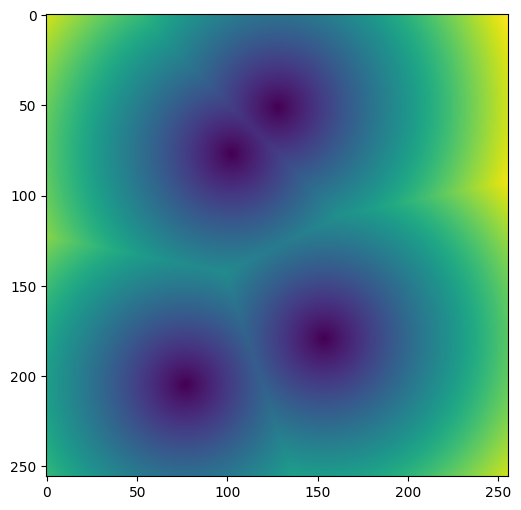

In [ ]:
# Case 2
batched_points = np.array([[[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]]])

plot_map(min_dist_scalable(batched_points, 256, 100000)[0], figsize=(6, 6))

Batch 0: 66chunk [00:00, 1782.76chunk/s]          
Batch 1: 66chunk [00:00, 2053.48chunk/s]          
Batch 2: 66chunk [00:00, 2029.74chunk/s]          


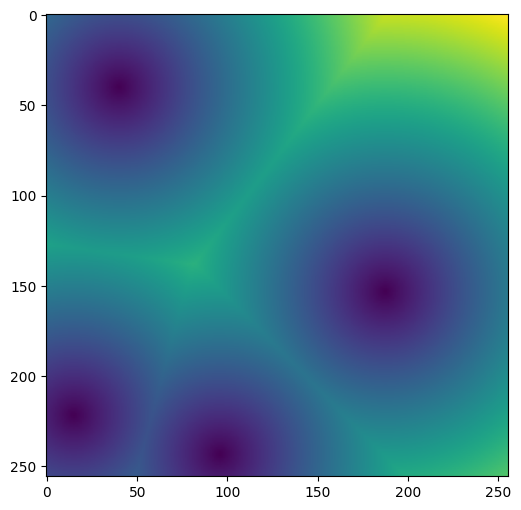

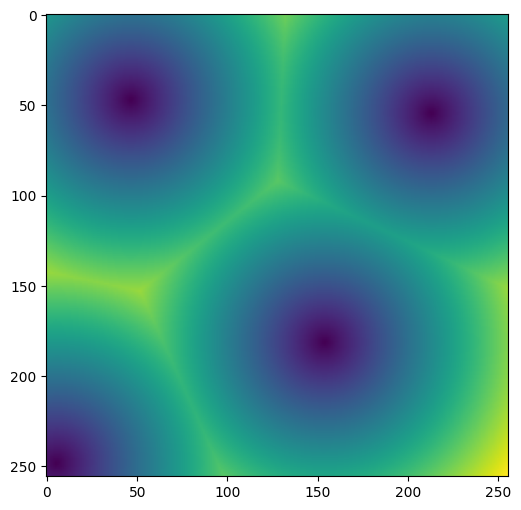

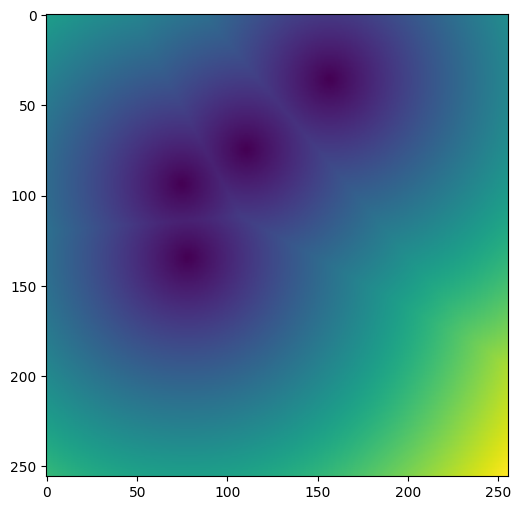

In [ ]:
# Case 3
batched_points = create_points(3, 4, seed=42)
distance_to_data = min_dist_scalable(batched_points, 256)
plot_map(distance_to_data[0])
plot_map(distance_to_data[1])
plot_map(distance_to_data[2])

## Resolution 16,384
This case actually does not need to reduce data precision. Even when using float32, the memory usage of one map is:

$16384^2 \times 4 = 1,073,741,824\ \text{bytes} \approx 1\ \text{GB}$

In [ ]:

batched_points = create_points(3, 4, seed=42)
distance_to_data = min_dist_scalable(batched_points, 16384, 100000, device="cuda")

# Cannot draw maps for resolution this large

Batch 0: 2685chunk [01:30, 29.54chunk/s]                       
Batch 1: 2685chunk [01:33, 28.65chunk/s]                       
Batch 2: 2685chunk [01:44, 25.72chunk/s]                       


## Resolution 65,536
In this case, it is necessary to reduce data precision. float32 uses 4 bytes, so the estimated memory used by a map of resolution 65536 * 65536 is:

$65536^2 \times 4 = 17,179,869,184 \text{ bytes} \approx 16 \text{GB}$

which over the available GPU memory of Colab. Using bfloat16 (costing 2 bytes per number), the memory usage of a map is about 8GB. bfloat16 also offer better numerical stability than float16 since it has more range (can represent more larger and smaller numbers)

However, Colab's free instance only has 15GB of GPU RAM, we can only create map for one batch of points in-memory. To create maps for more than one batch, we can also consider writing the created map to local storage and start creating new maps from scratch.

In [ ]:
batched_points = create_points(1, 4, seed=42)
distance_to_data = min_dist_scalable(batched_points, 65536, 100000, device="cuda", dtype=torch.bfloat16)

Batch 0: 100%|██████████| 42950/42950.0 [29:53<00:00, 23.95chunk/s]
